# VO: Visual odometry

Given a sequence of images:
$$
\{ 
    I_1, I_2, \cdot\cdot\cdot, I_n
\}
$$
Find the motion / trajectory 

$$
\{ 
(R_1, t_1), (R_2, t_2), \cdot\cdot\cdot, (R_{n-1}, t_{n-1})
\}
$$

such that 
$$
\{
 R_i f(I_i) + t_i \quad \text{best aligns with} \quad f(I_{i+1}), \quad i = 1, 2,...,n-1)  
\}
$$


## 0: Loading and Visualizing the Data

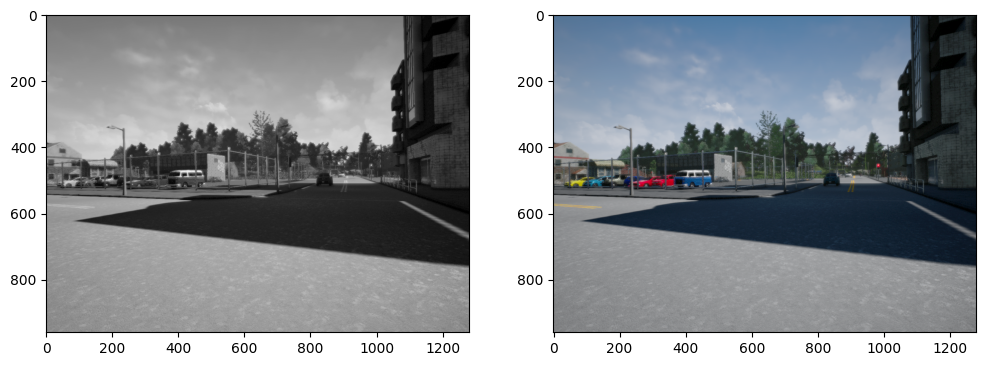

In [20]:
import cv2
from m2bk import *
import numpy as np
from matplotlib import pyplot as plt

data = DatasetHandler()
images = data.images 
rgb_images = data.images_rgb
depths = data.depth_maps

# plot images[0], rgb_images[0] side by side
_, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(images[0], cmap='gray')
ax[1].imshow(rgb_images[0])

# 1: Extracting features 

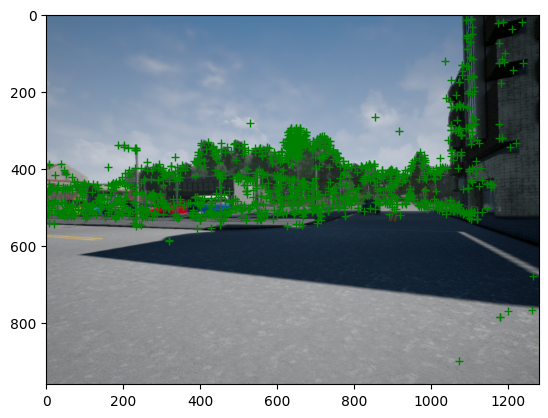

In [21]:
# f: extract features for the image
# returns:
# 1) a list of cv2.KeyPoint [kp1, kp2, ..., kpN]
# 2) an array of (128, ) vectors. 
#    each 128-vector represents a feature/keypoint descriptor  
def f(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

keypoints, descriptors = f(images[0])

def visualize_features(img, keypoints):
    ax = plt.subplot()
    ax.imshow(img)
    x = [ int(kp.pt[0]) for kp in keypoints ]
    y = [ int(kp.pt[1]) for kp in keypoints ]
    ax.plot(x, y, "g+")

visualize_features(rgb_images[0], keypoints)

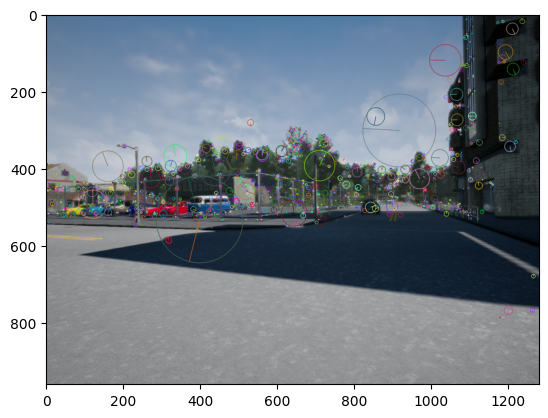

In [22]:
def cv2_visualize_features(img, keypoints):
    img_with_kp = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_with_kp)

cv2_visualize_features(rgb_images[0], keypoints)

# 2: Feature Matching

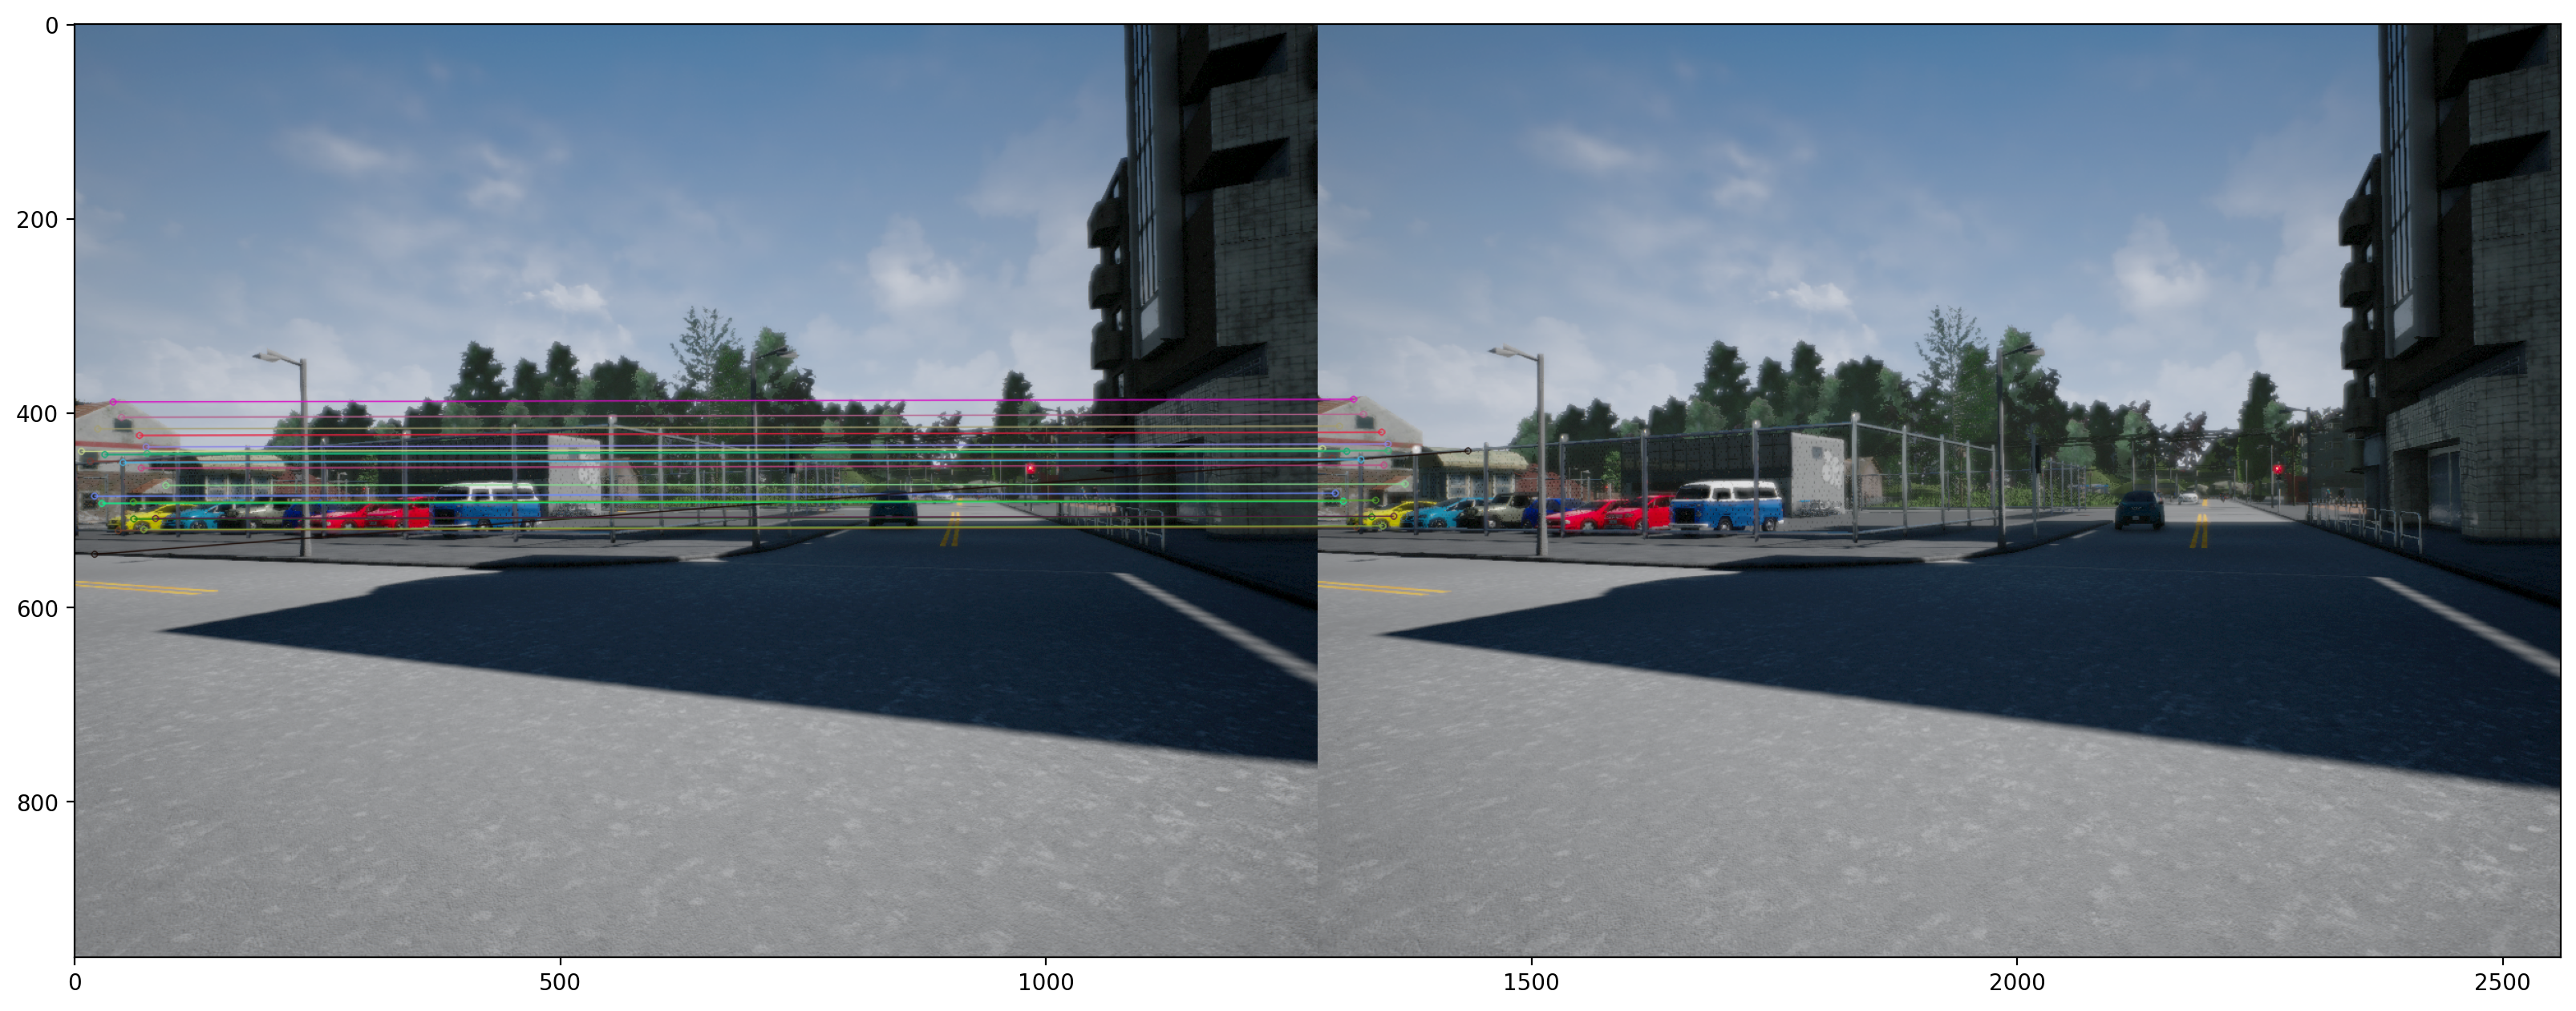

In [23]:
def match_features(descriptors1, descriptors2, ratio=0.5):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)
    return good_matches

def visualize_matches(I1, I2, keypoints1, keypoints2, matches, num_matches=10):
    matched_image = cv2.drawMatches(I1, keypoints1, I2, keypoints2, matches[:num_matches], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(20, 10), dpi=200)
    plt.imshow(matched_image)

keypoints1, descriptors1 = f(images[0])
keypoints2, descriptors2 = f(images[1])
matches = match_features(descriptors1, descriptors2)
visualize_matches(rgb_images[0], rgb_images[1], keypoints1, keypoints2, matches, num_matches=20)


In [ ]:
def match_features_all(images, f, match_features):
    all_matches = []
    all_keypoints = []
    all_descriptors = []
    N = len(images)
    for i in range(N - 1):
        keypoints1, descriptors1 = f(images[i])
        keypoints2, descriptors2 = f(images[i + 1])
        matches = match_features(descriptors1, descriptors2)
        all_matches.append(matches)
        all_keypoints.append((keypoints1, keypoints2))
        all_descriptors.append((descriptors1, descriptors2))
        
    return all_matches, all_keypoints, all_descriptors

# 3: Trajectory estimation

In [25]:
from numpy.linalg import inv
def estimate_motion(matches, kpoints1, kpoints2, K, depth1=None):
    # Estimate camera motion from a pair of subsequent image frames
    # Arguments:
    #   matches -- list of matched features from the pair of images
    #   kpoints1 -- list of the keypoints in the first image
    #   kpoints2 -- list of the keypoints in the second image
    #   K -- camera calibration matrix, a 3x3 numpy array
    #   depth1 -- a depth map of the first frame. depth1[v, u] gives the depth value at pixel (u, v) in the first image.
    # Returns:
    #   R -- recovered 3x3 rotation numpy matrix
    #   t -- recovered 3x1 translation numpy vector
    #   image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [u, v], where u and v are 
    #                  coordinates of the i-th match in the image coordinate system
    #   image2_points -- a list of selected match coordinates in the second image. image2_points[i] = [u, v], where u and v are 
    #                  coordinates of the i-th match in the image coordinate system               
    R = np.eye(3)
    t = np.zeros((3, 1))
    image1_points = []
    image2_points = []
    object_points = []
    for m in matches:
        u1, v1 = kpoints1[m.queryIdx].pt
        u2, v2 = kpoints2[m.trainIdx].pt
        z = depth1[int(v1), int(u1)]
        if z <= 0 or z >= 1000:  # filter out invalid depth values
            continue

        I1pt = np.array([u1 * z, v1 * z, z])

        # [u1 * z, v1 * z, z] = K @ [Xc, Yc, Zc]
        XYZc = inv(K) @ I1pt # XYZC is the 3D point in the camera frame of the first image
        object_points.append(XYZc)
        image1_points.append([u1, v1])
        image2_points.append([u2, v2])
    
    object_points = np.array(object_points, dtype=np.float32)
    image2_points = np.array(image2_points, dtype=np.float32)
    if len(object_points) >= 5:  # minimum number of points for solvePnP
        _, R_vec, t, _ = cv2.solvePnPRansac(object_points, image2_points, K, None)
        R, _ = cv2.Rodrigues(R_vec)

    return R, t, image1_points, image2_points

In [26]:
all_matches, all_keypoints, all_descriptors = match_features_all(images, f, match_features)

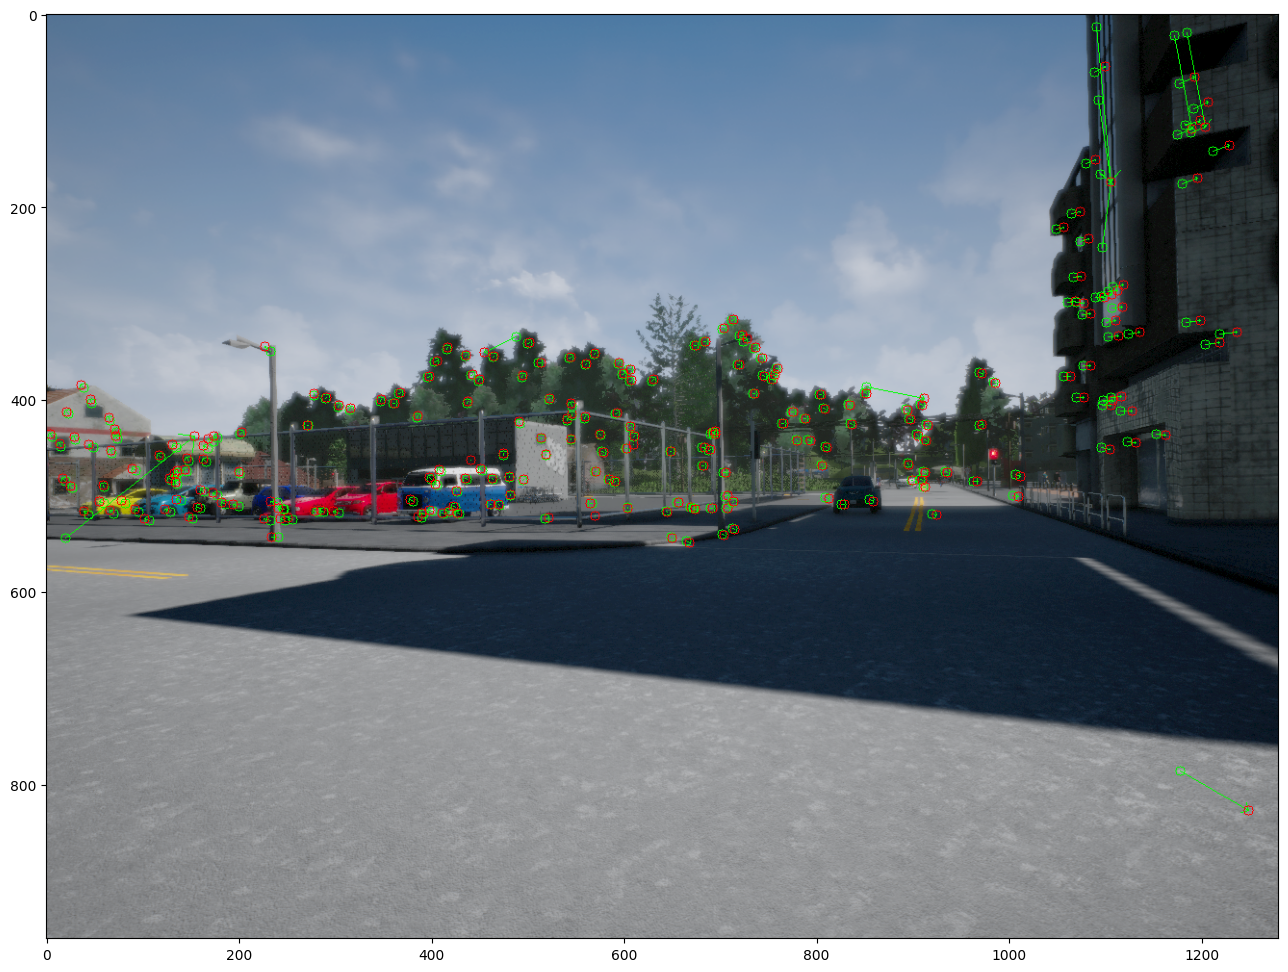

In [27]:
K = data.k
i = 0

matches = all_matches[i]
kpoints1, kpoints2 = all_keypoints[i]
R, t, image1_points, image2_points = estimate_motion(matches, kpoints1, kpoints2, K, depth1=depths[i])

image_move = visualize_camera_movement(rgb_images[i], image1_points, rgb_images[i + 1], image2_points)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)

In [ ]:
# RANSAC 
# 1. init
#       Given the model ([u[i], v[i])[1])  + [tu, tv] = ([u[i], v[i])[2])
#       find M, smallest number of random data points, to estimate the model parameters 
# Loop 
#       2. Randomly choose M data points
#       3. Compute model parameters using chosen M data points      
#       4. Check how many data points from the rest of the data fit the model, create C
#       5. If the set C is too small, go back to step 2
#          Else return C 
# 
# Last 
#      6. Recompute model parameters using inliers set C

def compute_t(match, keypoints1, keypoints2):
    # Compute model parameters tu, tv
    k1 = match.queryIdx
    k2 = match.trainIdx
    u1, v1 = keypoints1[k1].pt
    u2, v2 = keypoints2[k2].pt
    tu = u2 - u1
    tv = v2 - v1
    return tu, tv

keypoints1, keypoints2 = all_keypoints[0]
descriptors1, descriptors1 = all_descriptors[0]
match12 = all_matches[0]
N = len(match12) 

# RANSAC 
# step 1: init M = 1
C = []
while (True):

    # step 2: Randomly choose  M=1 data point
    randomIdx = np.random.randint(0, N)
    match = match12[randomIdx]

    # step 3: Compute model parameters tu, tv
    tu, tv = compute_t(match, keypoints1, keypoints2)

    # step 4: check the rest of data to see how many samples fit the model
    for m1, m2 in match12:
        tu0, tv0  = compute_t(m1, keypoints1, keypoints2)
        if np.linalg.norm( np.array([tu0, tv0])  - np.array([tu, tv]) ) < 1e-3:
            C.append(m1)
    
    # step 5: if len(C) < 0.9 * N, then 
    if len(C) < 0.6 * N:
        continue
    
    break

# step 6: 
tu2sum = 0
tv2sum = 0
for match in C:
    # Compute model parameters tu, tv
    k1 = match.queryIdx
    k2 = match.trainIdx
    u1, v1 = keypoints1[k1].pt
    u2, v2 = keypoints2[k2].pt

    tu2sum += (u2 - u1)**2
    tv2sum +=  (v2 - v1)**2

tu = np.sqrt(tu2sum/len(C))
tv = np.sqrt(tv2sum/len(C))
t = np.array([tu, tv])
print(t)


312